In [1]:
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
from napari.utils import nbscreenshot
import os

from skimage.registration import phase_cross_correlation
from skimage.transform import SimilarityTransform
import cv2 as cv
from skimage import io
from PyQt5 import QtCore
import cupy as cp 

import imagej
%gui qt 
%matplotlib inline


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
# main_folder = r'E:\Ed\PSFCheck\20220318_Grid\20220318_M25_1'
main_folder = r'E:\Ed\PSF_defocus\20220311_M25_tamron_m25v2mfg2_3rows\20220311_M25_PSF4'
# main_folder = r'E:\Ed\PSF_defocus\20220315_M25_MFGlowindex\20220315_M25_PSF1'
# main_folder = r'E:\Ed\Data\test_flies\20220322_M25_larvae_05'

# folder = r'E:\Ed\PSF\20220124_M25_allcameras\CAM_Z2'
# file_extension = folder + '/' + '*.raw'
folder_names = sorted(glob(main_folder+ '/CAM*/'), key=alphanumeric_key)
offsets_file = os.path.join(main_folder,"offsets.csv")

# file_names = sorted(glob(file_extension),key=alphanumeric_key)

In [ ]:
# Load offsets from desired folder 
main_folder = r'E:\Ed\PSF_defocus\20220318_M25_tamronall24cams_mfgno2\20220318_M25_PSF2'
offsets_file_load = os.path.join(main_folder,"offsets.csv")
with open(offsets_file_load) as file_name:
    offsets = np.loadtxt(file_name, delimiter=",")

In [4]:
# Read RAW files and return Dask Array
def imread_raw(raw_file, width=960, height=600, px_size='uint16'):
    raw_img = np.fromfile(raw_file, dtype= px_size)
    raw_reshape =np.reshape(raw_img,(1,height,width))
    return da.from_array(raw_reshape)

# # Read RAW files and return Dask Array
# def imread_raw(raw_file, width=960, height=600, px_size='uint8'):
#     raw_img = np.fromfile(raw_file, dtype= px_size)
#     raw_reshape =np.reshape(raw_img,(1,height,width))
#     return da.from_array(raw_reshape)

def dask_raw_ds(folder_name,px_depth):
    file_extension = folder_name + '/' + '*.raw'
    file_names = sorted(glob(file_extension),key=alphanumeric_key)
    raw_ds = [ imread_raw(fn,960,600,px_size= px_depth) for fn in file_names]
    # dask_raw_ds = da.stack(raw_ds,axis=1)
    return raw_ds

In [5]:
px_depth = 'uint16'
# px_depth = 'uint8'
height = 600
width =960

raw_M25_volume = [dask_raw_ds(fd,px_depth) for fd in folder_names]
stack = da.concatenate(raw_M25_volume, axis=1)
# stack_max_projection= np.array([ da.max(stack[:,i,:,:],axis=0) for i in range(stack.shape[1])])


In [6]:
viewer=napari.Viewer()
viewer.add_image(stack)

<Image layer 'stack' at 0x21a2a7ff5b0>

In [7]:
def registration(img_stack,ref_index):
    t,c,h,w =img_stack.shape
    stack_max_projection= np.array([ da.max(img_stack[:,i,:,:],axis=0) for i in range(img_stack.shape[1])])
    offset = np.array([phase_cross_correlation(stack_max_projection[ref_index], stack_max_projection[i]) for i in range(stack_max_projection.shape[0])],dtype=object)
    offset = offset[0:c,0]
    offset_coords = np.stack(offset[0:,],axis=0)
    return offset_coords

def align_projections(img_stack,offsets):
    stack_max_projection= np.array([ da.max(img_stack[:,i,:,:],axis=0) for i in range(img_stack.shape[1])])
    shifted= np.zeros_like(stack_max_projection)
    for i in range(img_stack.shape[1]):
        x_offset,y_offset = offsets[i]
        M = np.float32([
        [1, 0, y_offset],
        [0, 1, x_offset]
        ])
        stack_max_projection= np.float32(stack_max_projection)
        # print(M)
        shifted[i] = cv.warpAffine(stack_max_projection[i],M,(stack_max_projection[i].shape[1],stack_max_projection[i].shape[0]))
    return shifted

def align_stack(img_stack,offsets):
    shifted= np.zeros_like(img_stack)
    print(img_stack.shape)
    width = img_stack.shape[3] 
    height = img_stack.shape[2]
    img_stack= np.float32(img_stack)
    for i in range(img_stack.shape[1] ):
        x_offset,y_offset = offsets[i,0]
        M = np.float32([
        [1, 0, y_offset],
        [0, 1, x_offset]
        ])
        
        for j in range(img_stack.shape[0]):
            shifted[j,i] = cv.warpAffine(img_stack[j,i],M,(width,height))
    
    return shifted


def np_align_stack(image_stack,offsets):
    from scipy.ndimage import shift 
    t,c,h,w = image_stack.shape
    
    shift_stack = np.zeros_like(image_stack)
    columns = np.zeros((offsets.shape[0],1))
    shift_stack_coord = np.hstack((columns,offsets))
    for i in range(c):
        shift_stack[:,i,:,:] = shift(image_stack[:,i,:,:],shift_stack_coord[i])
    return shift_stack

## Problem with this functino is that it doesnt de-allocate the memory from GPU so it will crash
# def cp_align_stack(np_image_stack,offsets):
#     import cupy as cp
#     from cupyx.scipy.ndimage import shift 
#     image_stack = cp.array(np_image_stack)
#     t,c,h,w = image_stack.shape
#     shift_stack = cp.zeros_like(image_stack)
#     columns = cp.zeros((offsets.shape[0],1))
#     shift_stack_coord = cp.hstack((columns,offsets))
#     for i in range(c):
#         shift_stack[:,i,:,:] = shift(image_stack[:,i,:,:],shift_stack_coord[i])
#     shift_stack = shift_stack.get()
#     mempool = cp.get_default_memory_pool()
#     pinned_mempool = cp.get_default_pinned_memory_pool()
#     mempool.free_all_blocks()
#     pinned_mempool.free_all_blocks()
#     return shift_stack

def cp_align(np_image_stack, offsets):
    from cupyx.scipy.ndimage import shift
    t,c,h,w = np_image_stack.shape
    shift_stack_cam = cp.zeros((c,h,w))
    shift_stack_output = []
    columns = cp.zeros((offsets.shape[0],1))
    shift_stack_coord = cp.hstack((columns,offsets))
    
    for i in range(c):
        cam_stack = cp.array(np_image_stack[:,i,:,:])
        shift_stack_cam= shift(cam_stack,shift_stack_coord[i])
        shift_stack_output.append(cp.asnumpy(shift_stack_cam))
        # TODO: Check  this is proper way of transfering from GPU to CPU
        shift_stack_cam = None
        cam_stack = None
        # print("post")
    shift_stack_coord = None
    aligned_stack = np.array(shift_stack_output)
    return np.moveaxis(aligned_stack,0,1)
    # return shift_stack_output

def cuda_mem_info(device_id =0):
    with cp.cuda.Device(device_id):
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()

        print(mempool.used_bytes())              # 
        print(mempool.total_bytes())             #
        print(pinned_mempool.n_free_blocks())    #

def cuda_clear(device_id=0):
    with cp.cuda.Device(device_id):
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()
        mempool.free_all_blocks()
        pinned_mempool.free_all_blocks()
        print(mempool.used_bytes())              # 
        print(mempool.total_bytes())             #
        print(pinned_mempool.n_free_blocks())    #

In [8]:
# viewer=napari.Viewer()
# viewer.add_image(stack)

In [9]:

def start_imagej():
    global ij
    ij = imagej.init(r'C:\Users\Callisto\Documents\edhirata\software\Fiji.app',headless=False)
    ij.ui().showUI()
    print(ij.getVersion())

QtCore.QTimer.singleShot(0, start_imagej)

In [10]:
# Align the files
aligned_volume_cp = cp_align(stack,offsets)
viewer.add_image(np.array(aligned_volume_cp))

2.3.0/1.53f


<Image layer 'Image' at 0x21bb2436790>

In [8]:
# def start_imagej():
#     global ij
#     ij = imagej.init(headless=False)
#     ij.ui().showUI()
#     print(ij.getVersion())

# QtCore.QTimer.singleShot(0, start_imagej)

In [11]:
ij_stack2  = ij.py.to_java(np.array(stack))
ij.ui().show('stack2',ij_stack2)

In [ ]:
#Get the Offsets and save in folder
offsets = registration(stack,11)
#Save the Offsets into the folder
np.savetxt(offsets_file, offsets, delimiter=',')

In [ ]:
# Align the files
aligned_volume_cp = cp_align(stack,offsets)
viewer.add_image(np.array(aligned_volume_cp))
ij_stack2  = ij.py.to_java(np.array(aligned_volume_cp,dtype='uint16'))
ij.ui().show('aligned_stack', ij_stack2)

In [ ]:
aligned_volume_cp.shape
cuda_mem_info()
cuda_clear()

In [11]:
ij_stack3  = ij.py.to_java(np.array(stack,dtype='uint16'))
ij.ui().show('aligned_stack2', ij_stack3)

## Lazy Loading

In [4]:
from dask import delayed
import dask

In [15]:
main_folder = r'E:\Ed\Data\20220412_celegans\20220412_M25_OH125265_2_L1-4a' # 5 curled up some slow movement
folder_names = sorted(glob(main_folder + '/CAM*/'), key=alphanumeric_key)

In [39]:
@dask.delayed
# Read RAW files and return Dask Array
def lazy_imread_raw(raw_file, width=960, height=600, px_size='uint8'):
    raw_img = np.fromfile(raw_file, dtype= px_size)
    raw_reshape =np.reshape(raw_img,(1,height,width))
    return raw_reshape



In [40]:
%%time
height =600
width = 960 
da_stack= []

for folder_name in folder_names:
    file_extension = folder_name + '/' + '*.raw'
    file_names = sorted(glob(file_extension),key=alphanumeric_key)
    sample =np.fromfile(file_names[0],dtype='uint8')
    raw_reshape =np.reshape(sample,(1,height,width))
    lazy_arrays = [lazy_imread_raw(fn) for fn in file_names]
    dask_arrays = [da.from_delayed(delayed_reader, shape=raw_reshape.shape,dtype=raw_reshape.dtype) for delayed_reader in lazy_arrays]
    # stack = da.concatenate(dask_arrays, axis=1)
    da_stack.append(dask_arrays)
stack = da.concatenate(da_stack,axis=1)
stack

CPU times: total: 2.58 s
Wall time: 2.57 s


,Array,Chunk
Bytes,6.71 GiB,562.50 kiB
Shape,"(500, 25, 600, 960)","(1, 1, 600, 960)"
Count,50000 Tasks,12500 Chunks
Type,uint8,numpy.ndarray


In [42]:
napari.view_image(stack,multiscale=False)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 299.5, 479.5), zoom=1.2429166666666667, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=4, ndisplay=2, last_used=0, range=((0.0, 500.0, 1.0), (0.0, 25.0, 1.0), (0.0, 600.0, 1.0), (0.0, 960.0, 1.0)), current_step=(250, 12, 300, 480), order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'stack' at 0x165b9ffda00>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None,

Exception in callback BaseAsyncIOLoop._handle_events(7104, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(7104, 1)>
Traceback (most recent call last):
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Callisto\Anaconda3\envs\napa

In [12]:
@dask.delayed
def load_dataset(main_folder,num_cams=25,px_depth='uint16'):
    # px_depth = 'uint16'
    # px_depth = 'uint8'
    folder_names = sorted(glob(main_folder + '/CAM*/'), key=alphanumeric_key)
    offset = np.floor(num_cams/2).astype(np.uint8)
    raw_M25_volume = [dask_raw_ds(fd,px_depth) for fd in folder_names[12-offset:offset+12]]
    stack = da.concatenate(raw_M25_volume, axis=1)
    return stack


    
@dask.delayed
def dask_raw_ds(folder_name,px_depth):
    file_extension = folder_name + '/' + '*.raw'
    file_names = sorted(glob(file_extension),key=alphanumeric_key)
    raw_ds = [ imread_raw(fn,960,600,px_size= px_depth) for fn in file_names]
    raw_ds = [da.from_delayed(delayed_reader,shape=sample.shape,dtype=sample.dtype)for delayed_reader in raw_ds]
    # dask_raw_ds = da.stack(raw_ds,axis=1)
    return raw_ds

In [14]:
viewer=napari.Viewer()
viewer.add_image(stack)

TypeError: Truth of Delayed objects is not supported

Exception in callback BaseAsyncIOLoop._handle_events(4724, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(4724, 1)>
Traceback (most recent call last):
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Callisto\Anaconda3\envs\napari-pymmcore\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Callisto\Anaconda3\envs\napa

## Testing Grounds 

#### Test the CUPY library to shift array

In [ ]:
# ij_stack2  = ij.py.to_java(np.array(stack))
# ij.ui().show('aligned_stack2',ij_stack2)
# offsets = registration(stack,12)
# #Save the Offsets into the folder
# np.savetxt(offsets_file, offsets, delimiter=',')

# mip_stack = align_projections(stack,offsets)
# #STACK IN IMAGEJ
# ij_stack  = ij.py.to_java(np.array(mip_stack))
# ij.ui().show('MIP_stack',ij_stack)

In [ ]:
#Save the Offsets into the folder
np.savetxt(offsets_file, offsets, delimiter=',')

In [ ]:
ij_stack2  = ij.py.to_java(np.array(stack))
ij.ui().show('stack2',ij_stack2)

In [ ]:
def start_imagej():
    global ij
    ij = imagej.init(headless=False)
    ij.ui().showUI()
    print(ij.getVersion())

QtCore.QTimer.singleShot(0, start_imagej)

In [ ]:
offsets = registration(stack,12)
mip_stack = align_projections(stack,offsets)
#STACK IN IMAGEJ
ij_stack  = ij.py.to_java(np.array(mip_stack))
ij.ui().show('stack',ij_stack)


ij_stack2  = ij.py.to_java(np.array(stack))
ij.ui().show('stack2',ij_stack2)


2.3.0/Inactive


[java.lang.Enum.toString] [INFO] Found 10 JHotDraw adapters.
[java.lang.Enum.toString] [INFO] Found 10 JHotDraw adapters.


In [ ]:
a = ij.window().getOpenWindows()
print(a)

# ij.from_java()

[MIP_stack, aligned_stack]


NameError: name 'autoclass' is not defined

In [ ]:
viewer=napari.Viewer()
def start_imagej():
    global ij
    ij = imagej.init(r'C:\Users\Callisto\Documents\edhirata\software\Fiji.app',headless=False)
    ij.ui().showUI()
    print(ij.getVersion())

QtCore.QTimer.singleShot(0, start_imagej)

In [ ]:

def cp_align(np_image_stack, offsets):
    from cupyx.scipy.ndimage import shift
    t,c,h,w = np_image_stack.shape
    shift_stack_cam = cp.zeros((c,h,w))
    shift_stack_output = []
    columns = cp.zeros((offsets.shape[0],1))
    shift_stack_coord = cp.hstack((columns,offsets))
    
    for i in range(c):
        cam_stack = cp.array(np_image_stack[:,i,:,:])
        shift_stack_cam= shift(cam_stack,shift_stack_coord[i])
        shift_stack_output.append(cp.asnumpy(shift_stack_cam))
        # TODO: Check  this is proper way of transfering from GPU to CPU
        shift_stack_cam = None
        cam_stack = None
        # print("post")
    shift_stack_coord = None
    # return shift_stack_output
    aligned_stack = np.array(shift_stack_output)
    return np.moveaxis(aligned_stack,0,1)
    
a = cp_align(stack,offsets)
viewer.add_image(a)

2.3.0/1.53f


<Image layer 'a' at 0x1c75d95f970>

In [ ]:
ij_stack3  = ij.py.to_java(np.array(a))
ij.ui().show('aligned',ij_stack3)

In [ ]:
import cupy as cp
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

# You can access statistics of these memory pools.
print(mempool.used_bytes())              # 0
print(mempool.total_bytes())             # 0
print(pinned_mempool.n_free_blocks())    # 0




6480000000
6480000000
3


In [ ]:
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [ ]:
aligned_volume = cupy_align_stack(stack,offsets)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
image_stack = stack 
t,c,h,w = image_stack.shape
shift_stack = np.zeros_like(image_stack)
columns = np.zeros((offsets.shape[0],1))
# print(shift_stack_coord)
# print(shift_stack_coord.shape)
# print(columns.shape)
# print(offsets.shape)
aligned_volume = np_align_stack(stack,offsets)


[[   0.  162.  442.]
 [   0.  235.  476.]
 [   0.  -10. -166.]
 [   0. -140. -174.]
 [   0. -127.   66.]
 [   0.  262.  325.]
 [   0.  153.  338.]
 [   0.  295.  462.]
 [   0. -293. -173.]
 [   0.   81.   41.]
 [   0.  -94.  253.]
 [   0.  -70. -273.]
 [   0.    0.    0.]
 [   0. -239.  443.]
 [   0.  147.  198.]
 [   0.  272. -284.]
 [   0.   20. -189.]
 [   0. -270.  179.]
 [   0.  136.  433.]
 [   0. -192. -280.]
 [   0.   21. -141.]
 [   0.  -57. -188.]
 [   0. -211. -337.]
 [   0.  130. -460.]
 [   0.  203.   24.]]
(25, 3)
(25, 1)
(25, 2)


array([   0.,  -10., -166.])

[[   0.  162.  442.]
 [   0.  235.  476.]
 [   0.  -10. -166.]
 [   0. -140. -174.]
 [   0. -127.   66.]
 [   0.  262.  325.]
 [   0.  153.  338.]
 [   0.  295.  462.]
 [   0. -293. -173.]
 [   0.   81.   41.]
 [   0.  -94.  253.]
 [   0.  -70. -273.]
 [   0.    0.    0.]
 [   0. -239.  443.]
 [   0.  147.  198.]
 [   0.  272. -284.]
 [   0.   20. -189.]
 [   0. -270.  179.]
 [   0.  136.  433.]
 [   0. -192. -280.]
 [   0.   21. -141.]
 [   0.  -57. -188.]
 [   0. -211. -337.]
 [   0.  130. -460.]
 [   0.  203.   24.]]


In [ ]:
import cupy as cp 
from cupyx.scipy.ndimage import shift 
t,c,h,w = stack.shape
test_stack = stack[:,10:13,:,:]
print(test_stack.shape)
c_1_np = np.array(test_stack[:,0,:,:]).astype(np.float32)
c_1 =cp.asarray(test_stack[:,0,:,:]).astype(np.float32)
print(c_1.shape)
offsets=registration(test_stack,1)
print(offsets)
x_offset,y_offset = offsets[0]
# shift_arr= cp.array([0,y_offset,x_offset])
shift_arr = shift(c_1[0,:,:].astype(float),offsets[0])
shift_arr_np = cp.asnumpy(shift_arr)

(257, 3, 600, 960)
(257, 600, 960)
[array([22., -3.]) array([0., 0.]) array([-9., -4.])]


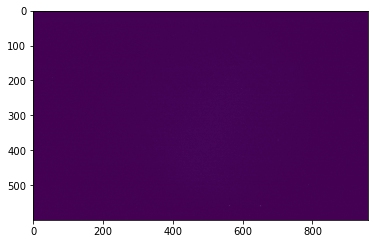

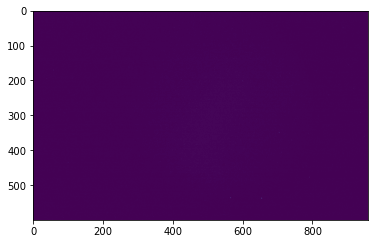

In [ ]:
plt.figure()
plt.imshow(shift_arr_np)
plt.figure()
plt.imshow(c_1_np[0,:,:])

In [ ]:
offsets

array([array([22., -3.]), array([0., 0.]), array([-9., -4.])],
      dtype=object)

In [ ]:
def start_imagej():
    global ij
    ij = imagej.init(headless=False)
    ij.ui().showUI()
    print(ij.getVersion())

QtCore.QTimer.singleShot(0, start_imagej)

2.3.0/1.53f


In [ ]:
#STACK IN IMAGEJ
ij_stack  = ij.py.to_java(np.array())
ij.ui().show('stack',ij_stack)


2.3.0/1.53f


In [ ]:
# Testing ImageJ to load the stack
t,c,h,w = stack.shape
test_stack = stack[:,10:13,:,:]
print(test_stack.shape)
c_1 =np.array(test_stack[:,0,:,:])
print(c_1.shape)
print(type(c_1))
c_1  = ij.py.to_java(c_1)
ij.ui().show('testing',c_1)

test_stack = np.array(test_stack)
test_stack  = ij.py.to_java(test_stack)
ij.ui().show('stack',test_stack)


(212, 3, 600, 960)
(212, 600, 960)
<class 'numpy.ndarray'>


In [ ]:
test = ['hello','many','ties']

if 'hello' in test:
    print("asdfasdf")


asdfasdf


In [ ]:
stack.shape
test_stack = stack[:,10:13,:,:]
offsets=registration(test_stack,1)
# aligned_volume = align_stack(test_stack,offsets)

In [ ]:
viewer = napari.Viewer()
# viewer.add_image(aligned_max_projections)
viewer.add_image(aligned_volume)

<Image layer 'aligned_volume' at 0x22a76c40df0>

In [ ]:
offsets = registration(stack,1)
aligned_max_projections = align_projections(stack,offsets)
aligned_volume = align_stack(stack,offsets)


(257, 25, 600, 960)


In [ ]:
#STACK IN IMAGEJ
ij_stack  = ij.py.to_java(np.array(aligned_volume))
ij.ui().show('stackvol',ij_stack)

In [ ]:
viewer = napari.Viewer()
# viewer.add_image(aligned_max_projections)
viewer.add_image(aligned_volume)

<Image layer 'aligned_volume' at 0x24caea05220>

Exception in callback BaseAsyncIOLoop._handle_events(6824, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(6824, 1)>
Traceback (most recent call last):
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\

In [ ]:
directory = 'aligned_dataset'
path_aligned = os.path.join(main_folder,directory)
os.mkdir(path_aligned)
output_filename = os.path.join(path_aligned,'aligned_stack.tif')
io.imsave(output_filename,aligned_volume)

C:\Users\Callisto\AppData\Local\Temp/ipykernel_33640/3214926037.py:5: UserWarning: E:\Ed\PSF\20220204_M25_defocusCam1\aligned_dataset\aligned_stack.tif is a low contrast image
  io.imsave(output_filename,aligned_volume)


Exception in callback BaseAsyncIOLoop._handle_events(6360, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(6360, 1)>
Traceback (most recent call last):
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Callisto\Anaconda3\envs\napari-env\lib\site-packages\